In [15]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from shap.datasets import adult
from ensemble import utils, Ensemble

In [16]:
# Load data
X, Y = adult()
X = X.values
Y = Y.astype(int)
print(f'X.shape = {X.shape}, Y.shape = {Y.shape}')

# Split into training, val, test
val_portion = 0.2
test_portion = 0.2

# Shuffle inds
np.random.seed(0)
inds = np.arange(len(X))
np.random.shuffle(inds)
num_val = int(len(X) * val_portion)
num_test = int(len(X) * test_portion)

# Apply split
X_val, Y_val = X[:num_val], Y[:num_val]
X_test, Y_test = X[num_val:num_val+num_test], Y[num_val:num_val+num_test]
X_train, Y_train = X[num_val+num_test:], Y[num_val+num_test:]
del X, Y
print(f'train examples = {len(X_train)}, val examples = {len(X_val)}, test examples = {len(X_test)}')

X.shape = (32561, 12), Y.shape = (32561,)
train examples = 19537, val examples = 6512, test examples = 6512


In [17]:
# Train models
np.random.seed(0)
num_features = 5
num_models = 10
models = []
for seed in range(num_models):
    # Generate feature mask
    inds = np.random.choice(X_train.shape[1], num_features, replace=False)
    mask = np.zeros(X_train.shape[1])
    mask[inds] = 1

    # Create LGBM datasets
    d_train = lgb.Dataset(X_train * mask, label=Y_train)
    d_val = lgb.Dataset(X_val * mask, label=Y_val)

    # Model parameters
    params = {
        'max_bin': 512,
        'learning_rate': 0.1,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 8,
        'verbose': -1,
        'min_data': 100,
        'boost_from_average': True,
        'random_state': seed
    }
    
    # Train
    model = lgb.train(params, d_train, num_boost_round=200, valid_sets=[d_val], early_stopping_rounds=50, verbose_eval=0)
    models.append(model)

In [18]:
# Calculate performance metrics for each model
for model in models:
    # Training performance
    preds = model.predict(X_train)
    train_loss = utils.log_loss(preds, Y_train)
    train_acc = utils.accuracy(preds, Y_train)

    # Validation performance
    preds = model.predict(X_val)
    val_loss = utils.log_loss(preds, Y_val)
    val_acc = utils.accuracy(preds, Y_val)
    print(f'Train loss = {train_loss:.2f}, train acc = {100 * train_acc:.2f}, val loss = {val_loss:.2f}, val acc = {100 * val_acc:.2f}')

Train loss = 0.43, train acc = 79.85, val loss = 0.45, val acc = 78.99
Train loss = 0.34, train acc = 84.12, val loss = 0.35, val acc = 83.08
Train loss = 0.43, train acc = 80.45, val loss = 0.45, val acc = 79.51
Train loss = 0.29, train acc = 86.71, val loss = 0.30, val acc = 85.92
Train loss = 0.38, train acc = 80.65, val loss = 0.38, val acc = 80.57
Train loss = 0.30, train acc = 86.20, val loss = 0.32, val acc = 85.33
Train loss = 0.34, train acc = 84.00, val loss = 0.35, val acc = 83.15
Train loss = 0.43, train acc = 80.85, val loss = 0.44, val acc = 79.71
Train loss = 0.41, train acc = 80.43, val loss = 0.42, val acc = 79.53
Train loss = 0.41, train acc = 82.86, val loss = 0.42, val acc = 82.86


In [19]:
# Aggregate validation and test predictions
val_preds = {f'LGBM ({i})': model.predict(X_val) for i, model in enumerate(models)}
test_preds = {f'LGBM ({i})': model.predict(X_test) for i, model in enumerate(models)}

# Evaluate models in isolation
val_loss = {name: utils.log_loss(preds, Y_val) for name, preds in val_preds.items()}
val_acc = {name: utils.accuracy(preds, Y_val) for name, preds in val_preds.items()}
test_loss = {name: utils.log_loss(preds, Y_test) for name, preds in test_preds.items()}
test_acc = {name: utils.accuracy(preds, Y_test) for name, preds in test_preds.items()}

# Try SQP solver

In [20]:
from ensemble import utils
from ensemble.sqp_solvers import solve_binary_logloss_probs, solve_binary_logloss_logits
from ensemble.sqp_solvers import binary_logloss_logits_helper

In [21]:
# Probs version
probs_weights = solve_binary_logloss_probs(list(val_preds.values()), Y_val)

# Logits version
logit_preds = [utils.stable_logit(preds) for preds in val_preds.values()]
nonneg_weights = solve_binary_logloss_logits(logit_preds, Y_val, 'nonnegative')
simplex_weights = solve_binary_logloss_logits(logit_preds, Y_val, 'simplex')

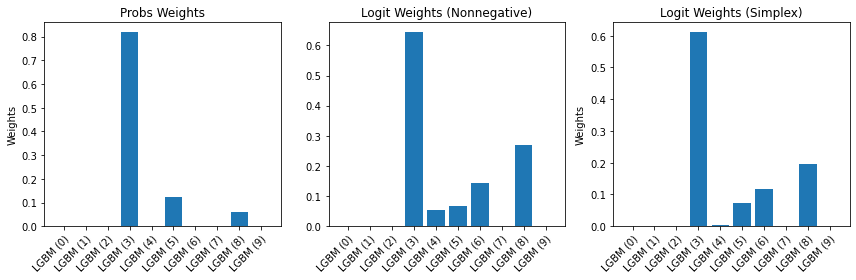

In [22]:
# Plot learned weights
fig, axarr = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(axarr[0])
plt.bar(range(len(models)), probs_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Probs Weights')
plt.ylabel('Weights')

plt.sca(axarr[1])
plt.bar(range(len(models)), nonneg_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Learned Ensemble Weights')
plt.title('Logit Weights (Nonnegative)')

plt.sca(axarr[2])
plt.bar(range(len(models)), simplex_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Logit Weights (Simplex)')
plt.ylabel('Weights')

plt.tight_layout()
plt.show()

# Compare to CVXPY solver

In [23]:
# Get weights from CVXPY solver
ensemble = Ensemble('binary:logloss_logits', 'simplex')
ensemble_simplex_weights = ensemble.solver(logit_preds, Y_val, 'simplex', verbose=True)
ensemble_nonneg_weights = ensemble.solver(logit_preds, Y_val, 'nonnegative')

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jul 29 12:08:56 AM: Your problem has 10 variables, 2 constraints, and 0 parameters.
(CVXPY) Jul 29 12:08:56 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 29 12:08:56 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 29 12:08:56 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 29 12:08:56 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 29 12:08:56 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [24]:
# Consistency between CVXPY and SQP
print(f'CVXPY objective value (simplex): {binary_logloss_logits_helper(logit_preds, Y_val, ensemble_simplex_weights)[0]}')
print(f'CVXPY objective value (nonneg): {binary_logloss_logits_helper(logit_preds, Y_val, ensemble_nonneg_weights)[0]}')
print(f'SQP objective value (simplex): {binary_logloss_logits_helper(logit_preds, Y_val, simplex_weights)[0]}')
print(f'SQP objective value (nonneg): {binary_logloss_logits_helper(logit_preds, Y_val, nonneg_weights)[0]}')

CVXPY objective value (simplex): 1925.721586709766
CVXPY objective value (nonneg): 1909.9091415403004
SQP objective value (simplex): 1925.7215867635723
SQP objective value (nonneg): 1909.9091438206044


# Confirm CVXPY version with probs still doesn't work

In [25]:
ensemble = Ensemble('binary:logloss_probs', 'simplex')
ensemble.fit(list(val_preds.values()), Y_val)

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

# Try unconstrained solver

In [26]:
unconstrained_weights = solve_binary_logloss_logits(logit_preds, Y_val, 'none', verbose=True)

Objective after step 1: 1916.6827622075853
Objective after step 2: 1883.2501179193741
Objective after step 3: 1880.165578937892
Objective after step 4: 1880.103384680016
Objective after step 5: 1880.1033364148732
Stopping after 5 steps


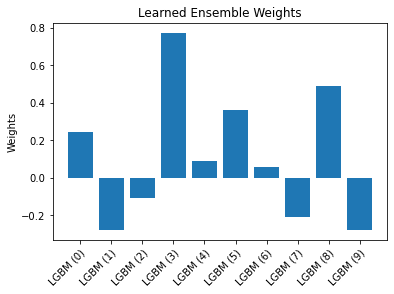

In [27]:
# Plot learned weights
plt.figure()
plt.bar(range(len(models)), unconstrained_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Learned Ensemble Weights')
plt.ylabel('Weights')
plt.show()

In [28]:
print(f'SQP objective value (nonneg): {binary_logloss_logits_helper(logit_preds, Y_val, unconstrained_weights)[0]}')

SQP objective value (nonneg): 1880.1033364148732
